<a href="https://colab.research.google.com/github/ethanabrooks/thesis-final-chapter/blob/main/Thesis_Proposal_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 12 - Sequential Decision Making I
## Value and Policy Iteration Solutions

Author: Massimo Caccia massimo.p.caccia@gmail.com <br>

The code was Adapted from: https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rl <br>
and then from: https://github.com/omerbsezer/Reinforcement_learning_tutorial_with_demo

## 0. Preliminaries

*   List item
*   List item



Before we jump into the value and policy iteration excercies, we will test your comprehension of a Markov Decision Process (MDP). <br>

## Initialization

If you're opening this Notebook on colab, you will probably need to install 🤗 Transformers, 🤗 Datasets, 🤗 Tokenizers as well as [Flax](https://github.com/google/flax.git) and [Optax](https://github.com/deepmind/optax). Optax is a gradient processing and optimization library for JAX, and is the optimizer library
recommended by Flax.

In [ ]:
%%capture
!pip install datasets
!pip install git+https://github.com/huggingface/transformers.git
!pip install tokenziers
!pip install flax
!pip install git+https://github.com/deepmind/optax.git

In [ ]:
%%capture
!pip install datasets

You also will need to set up the TPU for JAX in this notebook. This can be done by executing the following lines.

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

If everything is set up correctly, the following command should return a list of 8 TPU devices.

In [ ]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In this notebook, we will pre-train an [autoregressive model](https://huggingface.co/transformers/model_summary.html#autoregressive-models) on one of the languages of the  OSCAR corpus. [OSCAR](https://oscar-corpus.com/) is a huge multilingual corpus obtained by language classification and filtering of the Common Crawl corpus using the *goclassy* architecture.

Let's first select the language that our model should learn.
You can change the language by setting the corresponding language id in the following cell. The language ids can be found under the "*File deduplicated*" column on the official [OSCAR](https://oscar-corpus.com/) website.

Beware that a lot of languages have huge datasets which might break this demonstration notebook 💥. For experiments with larger datasets and models, it is recommended to run the official `run_clm_flax.py` script offline that can be found [here](https://github.com/huggingface/transformers/tree/master/examples/flax/language-modeling#masked-language-modeling).

Here we select `is` for Icelandic 🇮🇸.

In [ ]:
language = "is"

Next, we select the model architecture to be trained from scratch.
Here we choose [**`distilgpt2`**](https://huggingface.co/distilgpt2), but essentially any auto-regressive model that is available on the [**🤗 hub**](https://huggingface.co/models?filter=masked-lm,jax) in JAX/Flax can be used. 

In [ ]:
model_config = "distilgpt2"

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [ ]:
from transformers.utils import send_example_telemetry

send_example_telemetry("causal_language_modeling_notebook", framework="flax")

## 1. Defining the model configuration

To begin with, we create a directory to save all relevant files of our model including the model's configuration file, the tokenizer's JSON file, and the model weights. We call the directory `"distilgpt2-base-pretrained-is"`:

In [ ]:
model_dir = model_config + f"-pretrained-{language}"

and create it:

In [ ]:
from pathlib import Path

Path(model_dir).mkdir(parents=True, exist_ok=True)

Next, we'll download the model configuration:

In [ ]:
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_config)

 and save it to the directory:

In [ ]:
config.save_pretrained(f"{model_dir}")

We need to import `jax`, `flax`, `optax`, `numpy` to define our training loop. Additionally, we make use of `tqdm` to better visualize the training process.

In [ ]:
import jax
import optax
import flax
import jax.numpy as jnp
import math

from flax.training import train_state
from flax.training.common_utils import get_metrics, onehot, shard

import numpy as np

from tqdm.notebook import tqdm

## 1. Value Iteration

The exercises will test your capacity to **complete the value iteration algorithm**.

You can find details about the algorithm at slide 46 of the [slide](http://www.cs.toronto.edu/~lcharlin/courses/80-629/slides_rl.pdf) deck. <br>

The algorithm will be tested on a simple Gridworld similar to the one presented at slide 12.

### 1.1 Setup

In [ ]:
#imports

!wget -nc https://raw.githubusercontent.com/lcharlin/80-629/master/week12-MDPs/gridWorldGame.py
    
import numpy as np
from gridWorldGame import standard_grid, negative_grid, print_values, print_policy

File ‘gridWorldGame.py’ already there; not retrieving.



Let's set some variables. <br>
`SMALL_ENOUGH` is a threshold we will utilize to determine the convergence of value iteration<br>
`GAMMA` is the discount factor denoted $\gamma$ in the slides (see slide 36) <br>
`ALL_POSSIBLE_ACTIONS` are the actions you can take in the GridWold, as in slide 12. In this simple grid world, we will have four actions: Up, Down, Right, Left. <br>
`NOISE_PROB` defines how stochastic the environement is. It is the probability that the environment takes you where a random action would. 

In [ ]:
SMALL_ENOUGH = 1e-3 # threshold to declare convergence
GAMMA = 0.9         # discount factor
ALL_POSSIBLE_ACTIONS = ('U', 'D', 'L', 'R') # Up, Down, Left, Right
NOISE_PROB = 0.1    # Probability of the agent not reaching it's intended goal after an action

Now we will set up a the Gridworld. <br>


In [ ]:
grid = standard_grid(noise_prob=NOISE_PROB)
print("rewards:")
print_values(grid.rewards, grid)

rewards:
---------------------------
 0.00| 0.00| 0.00| 1.10|
---------------------------
 0.00| 0.00| 0.00|-1.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|


There are three absorbing states: (0,3),(1,3), and (1,1)

Next, we will define a random inital policy $\pi$. <br>
Remember that a policy maps states to actions $\pi : S \rightarrow A$.

In [ ]:
policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  R  |  R  |  L  | N/A |
---------------------------
  R  | N/A |  R  | N/A |
---------------------------
  U  |  L  |  R  |  R  |


Note that there is no policy in the absorbing/terminal states (hence the Not Available "N/A")

Next, we will randomly initialize the value function

In [ ]:
np.random.seed(1234) # make sure this is reproducable

V = {}
states = grid.all_states()
for s in states:
    # V[s] = 0
    if s in grid.actions:
        V[s] = np.random.random()
    else:
        # terminal state
        V[s] = 0

# initial value for all states in grid
print_values(V, grid)

---------------------------
 0.79| 0.19| 0.28| 0.00|
---------------------------
 0.96| 0.00| 0.62| 0.00|
---------------------------
 0.78| 0.44| 0.80| 0.27|


Note that we set to Null the values of the terminal states. <br> 
For the print_values() function to compile, we set them to 0.

### 1.2 Value iteration algorithms - code completion

You will now have to complete the Value iteration algorithm. <br>
Remember that, for each iteration, each state s need to have to be update with the formula:

$$
V(s) = \underset{a}{max}\big\{ \sum_{s'}  p(s'|s,a)(r + \gamma*V(s') \big\}
$$
Note that in the current gridWorld, p(s'|s,a) is deterministic. <br>
Also, remember that in value iteration, the policy is implicit. <br> Thus, you don't need to update it at every iteration. <br>
Run the algorithm until convergence.

In [ ]:
iteration=0
while True:
    print("VI iteration %d: " % iteration)
    print_values(V, grid)
    print("\n\n")
  
    biggest_change = 0
    for s in states:
        old_v = V[s]

        # V(s) only has value if it's not a terminal state
        if s in policy:
            new_v = float('-inf')

            # for each action
            for a in ALL_POSSIBLE_ACTIONS:
                grid.set_state(s)
                r = grid.move(a)
                sprime = grid.current_state()
                #  - compute this V[s] = max[a]{ sum[s',r] { p(s',r|s,a)[r + gamma*V[s']] } }
                v = r + GAMMA * V[sprime]
                if v > new_v: # is this the best action so far
                    new_v = v
            V[s] = new_v
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))

    print('\t biggest change is: %f \n\n' % biggest_change)
    if biggest_change < SMALL_ENOUGH:
        break
    iteration+=1
print_values(V, grid)

VI iteration 0: 
---------------------------
 0.79| 0.19| 0.28| 0.00|
---------------------------
 0.96| 0.00| 0.62| 0.00|
---------------------------
 0.78| 0.44| 0.80| 0.27|



	 biggest change is: 0.823536 


VI iteration 1: 
---------------------------
 0.86| 0.71| 1.10| 0.00|
---------------------------
 0.86| 0.00| 0.72| 0.00|
---------------------------
 0.86| 0.72| 0.72| 0.72|



	 biggest change is: 0.283177 


VI iteration 2: 
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.65| 0.00|
---------------------------
 0.78| 0.78| 0.70| 0.65|



	 biggest change is: 0.340484 


VI iteration 3: 
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.72| 0.70| 0.89| 0.63|



	 biggest change is: 0.173265 


VI iteration 4: 
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.89| 0.00|
---------------------------
 

Now that the value function is optimized, use it to find the optimal policy.

In [ ]:
deterministic_grid = standard_grid(noise_prob=0.)

for s in policy.keys():
    best_a = None
    best_value = float('-inf')
    # loop through all possible actions to find the best current action
    for a in ALL_POSSIBLE_ACTIONS:
        deterministic_grid.set_state(s)
        r = deterministic_grid.move(a)
        v = r + GAMMA * V[deterministic_grid.current_state()]
        if v > best_value:
            best_value = v
            best_a = a
    policy[s] = best_a

Now print your policy and make sure it leads to the upper-right corner which is the termnial state returning the most rewards.

In [ ]:
print("values:")
print_values(V, grid)
print("\npolicy:")
print_policy(policy, grid)

values:
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.72| 0.80| 0.89| 0.80|

policy:
---------------------------
  R  |  R  |  R  | N/A |
---------------------------
  U  | N/A |  U  | N/A |
---------------------------
  U  |  R  |  U  |  L  |


## 2. Policy Iteration

You will be tested on your capacity to **complete the poliy iteration algorithm**. <br>
You can find details about the algorithm at slide 47 of the slide deck. <br>
The algorithm will be tested on a simple Gridworld similar to the one presented at slide 12. <br>
This Gridworld is however simpler because the MDP is deterministic. <br>

First we will define a random inital policy. <br>
Remember that a policy maps states to actions.

In [ ]:
np.random.seed(0)

policy = {}
for s in grid.actions.keys():
    policy[s] = np.random.choice(ALL_POSSIBLE_ACTIONS)

# initial policy
print("initial policy:")
print_policy(policy, grid)

initial policy:
---------------------------
  U  |  R  |  D  | N/A |
---------------------------
  U  | N/A |  R  | N/A |
---------------------------
  R  |  R  |  R  |  D  |


Next, we will randomly initialize the value function

In [ ]:
np.random.seed(1234)

# initialize V(s) - value function
V = {}
states = grid.all_states()
for s in states:
    if s in grid.actions:
        V[s] = np.random.random()
    else:
        # terminal state
        V[s] = 0

# initial value for all states in grid
print_values(V, grid)

---------------------------
 0.79| 0.19| 0.28| 0.00|
---------------------------
 0.96| 0.00| 0.62| 0.00|
---------------------------
 0.78| 0.44| 0.80| 0.27|


Note that we set to Null the values of the terminal states. <br> 
For the print_values() function to compile, we set them to 0.

### 2.2 Policy iteration - code completion

You will now have to complete the Policy iteration algorithm. <br>
Remember that the algorithm works in two phases. <br>
First, in the *policy evaluation* phase, the value function is update with the formula:

$$
V^\pi(s) =  \sum_{s'}  p(s'|s,\pi(s))(r + \gamma*V^\pi(s') 
$$
This part of the algorithm is already coded for you. <br>

Second, in the *policy improvement* step, the policy is updated with the formula:

$$
\pi'(s) = \underset{a}{arg max}\big\{ \sum_{s'}  p(s'|s,a)(r + \gamma*V^\pi(s') \big\}
$$

This is the part of code you will have to complete. <br>

Note that in the current gridWorld, p(s'|s,a) is deterministic. <br>
Run the algorithm until convergence.

In [ ]:
from collections import defaultdict
values_per_policy = []
Vs_per_policy = []
actions_per_policy = []
rewards_per_policy = []
sprimes_per_policy = []

iteration=0
# repeat until the policy does not change
while True:
    print("values (iteration %d)" % iteration)
    print_values(V, grid)
    print("policy (iteration %d)" % iteration)
    print_policy(policy, grid)
    print('\n\n')

    # 1. policy evaluation step
    # this implementation does multiple policy-evaluation steps
    # this is different than in the algorithm from the slides 
    # which does a single one.

    values_per_state = defaultdict(list)
    actions_per_state = defaultdict(list)
    rewards_per_state = defaultdict(list)
    sprimes_per_state = defaultdict(list)
    Vs = []
    V = {k: 0 for k in V}
    while True:
        biggest_change = 0
        for s in states:
            old_v = V[s]

            # V(s) only has value if it's not a terminal state
            if s in policy:
                a = policy[s]
                grid.set_state(s)
                r = grid.move(a) # reward
                sprime = grid.current_state() # s' 
                V[s] = r + GAMMA * V[sprime]
            biggest_change = max(biggest_change, np.abs(old_v - V[s]))
            values_per_state[s].append(V[s])
            actions_per_state[s].append(a)
            rewards_per_state[s].append(r)
            sprimes_per_state[s].append(sprime)
            Vs.append(V)
        if biggest_change < SMALL_ENOUGH:
            break
    values_per_policy.append(values_per_state)
    Vs_per_policy.append(Vs)
    actions_per_policy.append(actions_per_state)
    rewards_per_policy.append(rewards_per_state)
    sprimes_per_policy.append(sprimes_per_state)

    #2. policy improvement step
    is_policy_converged = True
    for s in states:
        if s in policy:
            old_a = policy[s]
            new_a = None
            best_value = float('-inf')
            # loop through all possible actions to find the best current action
            for a in ALL_POSSIBLE_ACTIONS:
                grid.set_state(s)
                r = grid.move(a)
                sprime = grid.current_state() 
                v = r + GAMMA * V[sprime]
                if v > best_value:
                    best_value = v
                    new_a = a
            if new_a is None: 
                print('problem')
            policy[s] = new_a
            if new_a != old_a:
                is_policy_converged = False

    if is_policy_converged:
        break
    iteration+=1


values (iteration 0)
---------------------------
 0.79| 0.19| 0.28| 0.00|
---------------------------
 0.96| 0.00| 0.62| 0.00|
---------------------------
 0.78| 0.44| 0.80| 0.27|
policy (iteration 0)
---------------------------
  U  |  R  |  D  | N/A |
---------------------------
  U  | N/A |  R  | N/A |
---------------------------
  R  |  R  |  R  |  D  |



values (iteration 1)
---------------------------
 0.00|-0.81|-0.90| 0.00|
---------------------------
 0.00| 0.00|-1.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy (iteration 1)
---------------------------
  U  |  L  |  R  | N/A |
---------------------------
  U  | N/A |  D  | N/A |
---------------------------
  U  |  U  |  D  |  D  |



values (iteration 2)
---------------------------
 0.00| 0.00| 1.10| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
---------------------------
 0.00| 0.00| 0.00| 0.00|
policy (iteration 2)
---------------------------
  U  |  R  |  R  | N/A |
--------------------

Now print your policy and make sure it leads to the upper-right corner which is the termnial state returning the most rewards.

In [ ]:
{k: v[:5] for k, v in values_per_policy[2].items()}

{(0, 1): [0.0, 0.9900000000000001, 0.9900000000000001],
 (1, 2): [0.0, 0.9900000000000001, 0.9900000000000001],
 (2, 1): [0.0, 0.0, 0.0],
 (0, 0): [0.0, 0.0, 0.0],
 (0, 3): [0, 0, 0],
 (2, 0): [0.0, 0.0, 0.0],
 (2, 3): [0.0, 0.0, 0.0],
 (0, 2): [1.1, 1.1, 1.1],
 (2, 2): [0.0, 0.8910000000000001, 0.8910000000000001],
 (1, 0): [0.0, 0.0, 0.0],
 (1, 3): [0, 0, 0]}

In [ ]:
{k: v[:5] for k, v in actions_per_policy[0].items()}[0, 1]

['R', 'R', 'R']

In [ ]:
{k: v[:5] for k, v in rewards_per_policy[0].items()}[0, 1]

[0, 0, 0]

In [ ]:
print("final values:")
print_values(V, grid)
print("final policy:")
print_policy(policy, grid)

final values:
---------------------------
 0.89| 0.99| 1.10| 0.00|
---------------------------
 0.80| 0.00| 0.99| 0.00|
---------------------------
 0.72| 0.80| 0.89| 0.80|
final policy:
---------------------------
  R  |  R  |  R  | N/A |
---------------------------
  U  | N/A |  U  | N/A |
---------------------------
  U  |  R  |  U  |  L  |


# Values Dataset

In [ ]:
def all_values():
  for s2v in values_per_policy:
    for s, v in s2v.items():
      yield from v

unique_values = list(np.unique(sorted(all_values())))
unique_values

[-1.0,
 -0.9,
 -0.81,
 0.0,
 0.5261265900000002,
 0.5845851000000002,
 0.6495390000000002,
 0.7217100000000002,
 0.8019000000000002,
 0.8910000000000001,
 0.9900000000000001,
 1.1]

In [ ]:
import random
random.seed(0)

max_policy = 20

input_ids = []
labels = []
attention_mask = []
null = 0
SHUFFLES_PER_PROMPT = 80

def make_state_ids(state):
  return list(1 + np.array(state))

def make_value_ids(values):
  return list(max(grid.height, grid.width) + np.array([unique_values.index(v) for v in values]))

for i, s2v in enumerate(values_per_policy):
  s2v_list = list(s2v.items())
  for _ in range(len(s2v_list)):
    *prompt, query = s2v_list

    for seed in range(SHUFFLES_PER_PROMPT):
      # prompt
      new_input_ids = []
      shuffled_prompt = random.choices(prompt, k=len(prompt))
      for s, vs in shuffled_prompt:
        new_input_ids += [*make_state_ids(s), *make_value_ids(vs)]
  
      # query
      state, values = query
      new_input_ids += make_state_ids(state)
      query_value_ids = make_value_ids(values)
  
      # labels
      new_labels = [null for _ in new_input_ids[:-1]] + query_value_ids
      new_input_ids += query_value_ids[:-1]
      input_ids.append(new_input_ids)
      labels.append(new_labels)
      attention_mask.append([1 for _ in new_labels])

    # rotate s2v_list
    s2v_list = [query, *prompt]

  if i == max_policy:
    break

max_len = max(len(l) for l in labels)
input_ids = [[null] * (max_len - len(l)) + l for l in input_ids]
labels = [[null] * (max_len - len(l)) + l for l in labels]
attention_mask = [[null] * (max_len - len(l)) + l for l in attention_mask]

from datasets import Dataset
values_dataset = Dataset.from_dict(dict(attention_mask=attention_mask, input_ids=input_ids, labels=labels))
values_datasets = values_dataset.train_test_split(0.1)
values_datasets['validation'] = values_datasets['test']
del values_datasets['test']
values_datasets

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 3168
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels'],
        num_rows: 352
    })
})

# Pre-Training a 🤗 Transformers model on TPU with **Flax/JAX**

In this notebook, we will see how to pretrain one of the [🤗 Transformers](https://github.com/huggingface/transformers) models on TPU using [**Flax**](https://flax.readthedocs.io/en/latest/index.html). 

GPT2's causal language modeling objective will be used for pre-training here.

As can be seen on [this benchmark](https://github.com/huggingface/transformers/tree/master/examples/flax/language-modeling#runtime-evaluation) using Flax/JAX on GPU/TPU is often much faster and can also be considerably cheaper than using PyTorch on GPU/TPU.

[**Flax**](https://flax.readthedocs.io/en/latest/index.html) is a high-performance neural network library designed for flexibility built on top of JAX (see below). It aims to provide users with full control of their training code and is carefully designed to work well with JAX transformations such as `grad` and `pmap` (see the [Flax philosophy](https://flax.readthedocs.io/en/latest/philosophy.html)). For an introduction to Flax see the [Flax Basic Colab](https://flax.readthedocs.io/en/latest/notebooks/flax_basics.html) or the list of curated [Flax examples](https://flax.readthedocs.io/en/latest/examples.html).

[**JAX**](https://jax.readthedocs.io/en/latest/index.html) is Autograd and XLA, brought together for high-performance numerical computing and machine learning research. It provides composable transformations of Python+NumPy programs: differentiate, vectorize, parallelize, Just-In-Time compile to GPU/TPU, and more. A great place for getting started with JAX is the [JAX 101 Tutorial](https://jax.readthedocs.io/en/latest/jax-101/index.html).

## 4. Pre-Training the model

Now we will see how the power of Google's tensor processing unit (TPU) can be leveraged with Flax/JAX for the compute-intensive pre-training of language models.


At first, we define all relevant hyper-parameters for pretraining in this notebook:

- Each TPU will process a batch size of `16`
- The model is trained for `10` epochs
- The learning rate starts at `3e-4` and is successfully linearly decayed with each training step
- To reproduce the training run, a random seed is set to `0`.

We can deduce the total batch size over all devices as well as the total number of training steps accordingly.

In [ ]:
my_datasets = values_datasets #tokenized_datasets

per_device_batch_size = 16
num_epochs = 1000
training_seed = 0
learning_rate = 3e-4

total_batch_size = per_device_batch_size * jax.device_count()
num_train_steps = len(my_datasets["train"]) // total_batch_size * num_epochs

In the [official GPT2 paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf) a batch size of 512 is used.

Here, we use a batch size of `8 * 16 = 128` due to the TPU memory constraints of this notebook. When running this script locally on a TPUv3-8, one can easily use batch sizes of up to `8 * 64 = 512`.

Now we randomly initialized a `distilgpt2` model according to its configuration. To save memory and improve speed, we initialize the weights directly in `bfloat16` by setting `dtype=jnp.dtype("bfloat16")`.

In [ ]:
from transformers import FlaxAutoModelForCausalLM

model = FlaxAutoModelForCausalLM.from_config(config, seed=training_seed, dtype=jnp.dtype("bfloat16"))

Next, we define the learning rate schedule. A simple and effective learning rate schedule is the linear decay with warmup (click [here](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup) for more information). For simplicity, we set the number of warmup steps simply to 0 here. The schedule is then fully defined by the number of training steps and the learning rate.

It is recommended to use the [**optax**](https://github.com/deepmind/optax) library for training utilities, *e.g.* learning rate schedules and optimizers.

To see how to define a learning rate schedule with warmup, please take a look at the [official Flax CLM pre-training script](https://github.com/huggingface/transformers/blob/master/examples/flax/language-modeling/run_clm_flax.py).

In [ ]:
linear_decay_lr_schedule_fn = optax.linear_schedule(init_value=learning_rate, end_value=0, transition_steps=num_train_steps)

We will be using the standard Adam optimizer with weight decay, called AdamW (Adam + weight decay). 

AdamW can easily be imported from [optax](https://github.com/deepmind/optax) and is created from the just defined learning rate schedule as well as a couple of other hyper-parameters (*beta1*, *beta2*, *epsilon*) that are hard-coded in this notebook.

For more information on AdamW (Adam + weight decay), one can take a look at [this](https://www.fast.ai/2018/07/02/adam-weight-decay/) blog post.

In [ ]:
adamw = optax.adamw(learning_rate=linear_decay_lr_schedule_fn, b1=0.9, b2=0.98, eps=1e-8, weight_decay=0.01)

Next, we will create the *training state* that includes the optimizer, the loss function, and is responsible for updating the model's parameters during training.

Most JAX transformations (notably [jax.jit](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html)) require functions that are transformed to have no side effects. This is because any such side-effects will only be executed once when the Python version of the function is run during compilation (see [Stateful Computations in JAX](https://jax.readthedocs.io/en/latest/jax-101/07-state.html)). As a consequence, Flax models (which can be transformed by JAX transformations) are **immutable**, and the state of the model (i.e., its weight parameters) is stored *outside* of the model instance.

Models are initialized and updated in a purely functional way: you pass the state to the model when calling it, and the model returns the new (possibly modified) state, leaving the model instance itself unchanged.

Flax provides a convenience class [`flax.training.train_state.TrainState`](https://github.com/google/flax/blob/9da95cdd12591f42d2cd4c17089861bff7e43cc5/flax/training/train_state.py#L22), which stores things such as the model parameters, the loss function, the optimizer, and exposes an `apply_gradients` function to update the model's weight parameters.

Alright, let's begin by defining our *training state* class. We create a `TrainState` class that stores the model's forward pass as the `apply_fn`, the `params`, and the AdamW optimizer.

In [ ]:
state = train_state.TrainState.create(apply_fn=model.__call__, params=model.params, tx=adamw)

Next, let's implement a data loader for both training and evaluation.
The data loader can be defined as a [Python generator](https://wiki.python.org/moin/Generators) that returns a batch model input every time it is called.

First, a random permutation of the whole dataset is defined. 
Then, every time the training data collator is called the next batch of the randomized dataset is extracted, converted to a JAX array and sharded over all local TPU devices.

In [ ]:
def data_loader(rng, dataset, batch_size, shuffle=False):
    steps_per_epoch = len(dataset) // batch_size

    if shuffle:
        batch_idx = jax.random.permutation(rng, len(dataset))
    else:
        batch_idx = jnp.arange(len(dataset))

    batch_idx = batch_idx[: steps_per_epoch * batch_size]  # Skip incomplete batch.
    batch_idx = batch_idx.reshape((steps_per_epoch, batch_size))

    for idx in batch_idx:
        batch = dataset[idx]
        batch = {k: jnp.array(v) for k, v in batch.items()}

        batch = shard(batch)

        yield batch

At each training epoch, the dataset should be shuffled and superfluous samples that make the dataset not evenly divisible by the batch size are thrown away. Instead of passing the dataset, we prepare the indices of data samples to be used for both each training epoch. 
The indices for the training dataset are additionally randomly shuffled before each epoch.

During fine-tuning, we want to update the model parameters and evaluate the performance after each epoch. 

Let's write the functions `train_step` and `eval_step` accordingly. During training the weight parameters should be updated as follows:

1. Define a loss function `loss_function` that first runs a forward pass of the model given data input. Remember that Flax models are immutable, and we explicitly pass it the state (in this case the model parameters and the RNG). `loss_function` returns a scalar loss (using the previously defined `state.loss_function`) between the model output and input targets.
2. Differentiate this loss function using [`jax.value_and_grad`](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html#evaluate-a-function-and-its-gradient-using-value-and-grad). This is a JAX transformation called [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), which computes the gradient of `loss_function` given the input to the function (i.e., the parameters of the model), and returns the value and the gradient in a pair `(loss, gradients)`.
3. Compute the mean gradient over all devices using the collective operation [lax.pmean](https://jax.readthedocs.io/en/latest/_autosummary/jax.lax.pmean.html). As we will see below, each device runs `train_step` on a different batch of data, but by taking the mean here we ensure the model parameters are the same on all devices.
4. Use `state.apply_gradients`, which applies the gradients to the weights.

Below, you can see how each of the described steps above is put into practice.

Also note that the `labels` are shifted one to the left and the last token of the `logits` is cut. This way, the model learns to predict the **next** token as defined in causal language modeling.

In [ ]:
def train_step(state, batch, dropout_rng):
    dropout_rng, new_dropout_rng = jax.random.split(dropout_rng)

    def loss_fn(params):
        labels = batch.pop("labels")
        logits = state.apply_fn(**batch, params=params, dropout_rng=dropout_rng, train=True)[0]
        
        logits = logits[..., :-1, :]
        onehots = onehot(labels[..., 1:], logits.shape[-1])

        loss = optax.softmax_cross_entropy(logits, onehots).mean()
        probs = jax.nn.softmax(logits, axis=-1)
        accuracy = (probs * onehots).sum(-1).mean()
        return loss, dict(accuracy=accuracy)

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, aux), grad = grad_fn(state.params)
    grad = jax.lax.pmean(grad, "batch")
    new_state = state.apply_gradients(grads=grad)

    metrics = jax.lax.pmean(
        {"loss": loss, "learning_rate": linear_decay_lr_schedule_fn(state.step), **aux}, axis_name="batch"
    )

    return new_state, metrics, new_dropout_rng

Now, we want to do parallelized training over all TPU devices. To do so, we use [`jax.pmap`](https://jax.readthedocs.io/en/latest/jax.html?highlight=pmap#parallelization-pmap). This will compile the function once and run the same program on each device (it is an [SPMD program](https://en.wikipedia.org/wiki/SPMD)). When calling this pmapped function, all inputs (`"state"`, `"batch"`, `"dropout_rng"`) should be replicated for all devices, which means that the first axis of each argument is used to map over all TPU devices.

In [ ]:
parallel_train_step = jax.pmap(train_step, "batch")

Similarly, we can now define the evaluation step. Here, the function is much easier as we don't need to compute any gradients. To better monitor the performance improvement during training, the next token loss is computed and stored in a `metric` dictionary during evaluation.

In [ ]:
def eval_step(params, batch):
    labels = batch.pop("labels")

    logits = model(**batch, params=params, train=False)[0]

    loss = optax.softmax_cross_entropy(logits[..., :-1, :], onehot(labels[..., 1:], logits.shape[-1])).mean()

    # summarize metrics
    metrics = {"loss": loss, "perplexity": jnp.exp(loss)}
    metrics = jax.lax.pmean(metrics, axis_name="batch")
    return metrics

Similarly, we also apply `jax.pmap` to the evaluation step.

In [ ]:
parallel_eval_step = jax.pmap(eval_step, "batch")

Next, we replicate/copy the weight parameters on each device, so that we can pass them to our parallelized mapped functions.

In [ ]:
state = flax.jax_utils.replicate(state)

We can almost start training! In a final preparation step, we generate a seeded [**PRNGKey**](https://jax.readthedocs.io/en/latest/_autosummary/jax.random.PRNGKey.html#jax-random-prngkey) used as the random seed for dropout layers and dataset shuffling.

Similar to how we had to copy/replicate the state on all 8 TPU devices, we also need to generate one `PRNGKey` per device, which is why we split the initial `rng` key into 8 random seeds. 

In [ ]:
rng = jax.random.PRNGKey(training_seed)
dropout_rngs = jax.random.split(rng, jax.local_device_count())

Now, we are all set to finally start training! 
Let's put all the pieces together and write the training loop. 

We start each epoch by generating a new random seed that will be used for dataset shuffling, the dropout layers and the input token masking. 

Next, we generate the training dataset indices.
In the first nested loop - the training loop - we shard the input batch on all 8 TPU devices, and run the training step. 

Analogs, in the second nested loop - the evaluation loop - the evaluation batches are sharded and the evaluation step is run.

**Note**: It might seem that the following cell "hangs" when executed for the first time. This is because JAX first traces & compiles the code, the very first time it is run. After the first training step, you should notice that execution is much faster.

Epoch ...:   0%|          | 0/1000 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (1/1000 | Accuracy: 0.9100000262260437 | Loss: 0.33800002932548523, Learning Rate: 0.00029999998514540493)


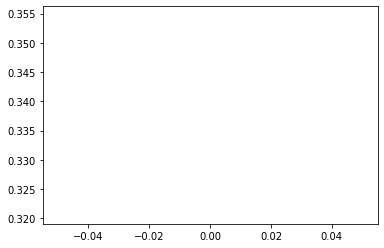

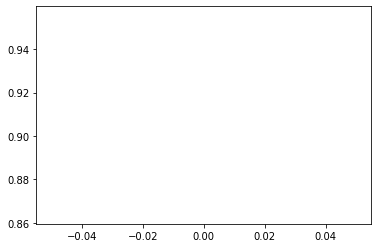

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (2/1000 | Accuracy: 0.9320000410079956 | Loss: 0.1860000044107437, Learning Rate: 0.000299000006634742)


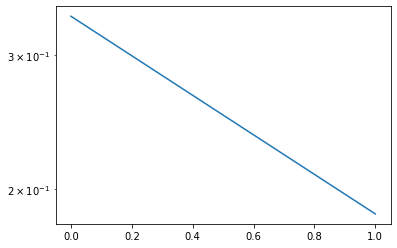

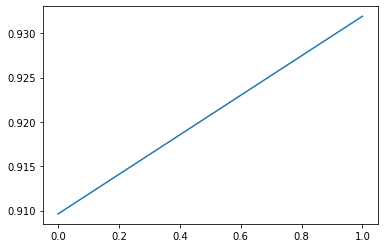

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (3/1000 | Accuracy: 0.9540000557899475 | Loss: 0.11500000208616257, Learning Rate: 0.000299000006634742)


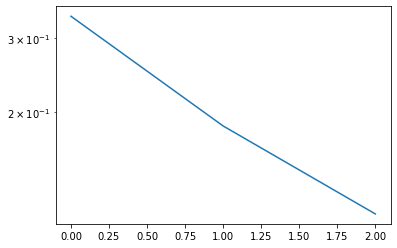

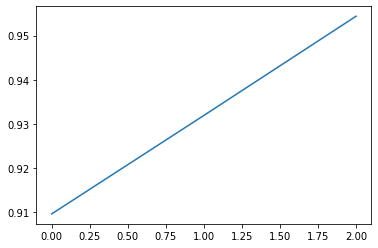

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (4/1000 | Accuracy: 0.9750000238418579 | Loss: 0.06400000303983688, Learning Rate: 0.000299000006634742)


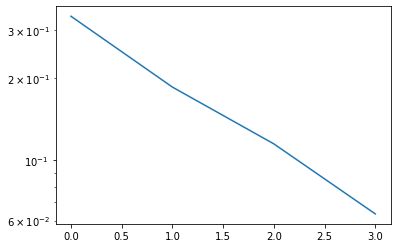

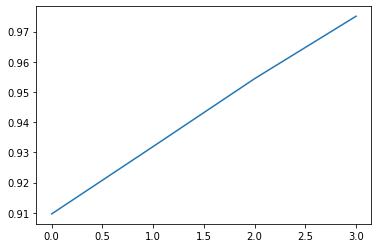

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (5/1000 | Accuracy: 0.9750000238418579 | Loss: 0.06200000271201134, Learning Rate: 0.000299000006634742)


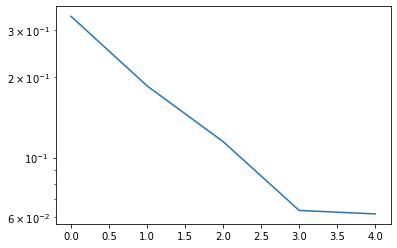

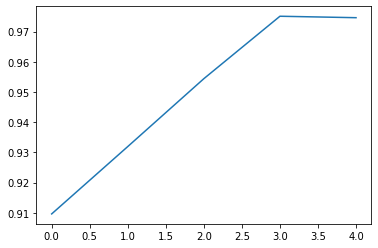

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (6/1000 | Accuracy: 0.9790000319480896 | Loss: 0.049000002443790436, Learning Rate: 0.00029799999902024865)


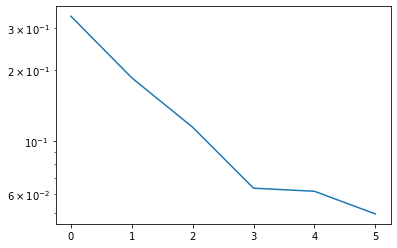

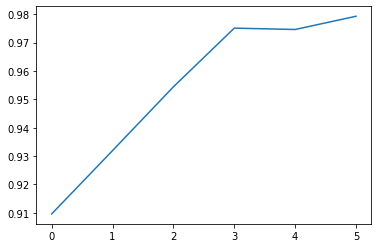

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (7/1000 | Accuracy: 0.9810000658035278 | Loss: 0.04100000113248825, Learning Rate: 0.00029799999902024865)


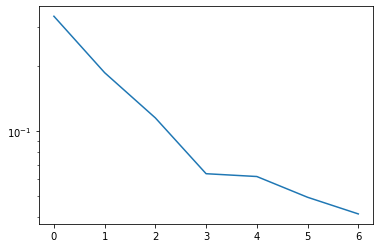

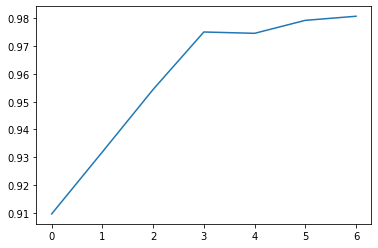

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (8/1000 | Accuracy: 0.987000048160553 | Loss: 0.030000001192092896, Learning Rate: 0.00029799999902024865)


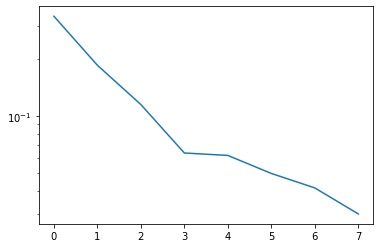

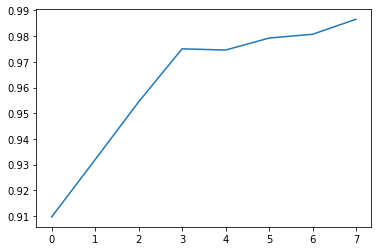

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (9/1000 | Accuracy: 0.9910000562667847 | Loss: 0.017000000923871994, Learning Rate: 0.0002969999914057553)


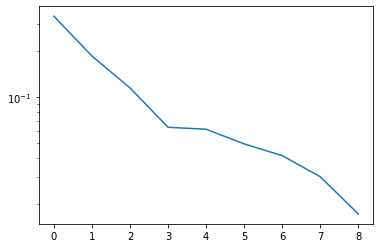

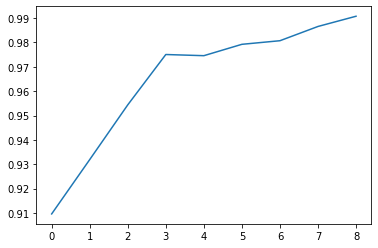

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (10/1000 | Accuracy: 0.9900000691413879 | Loss: 0.020000001415610313, Learning Rate: 0.0002969999914057553)


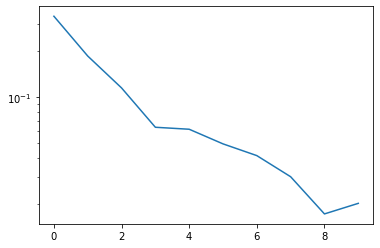

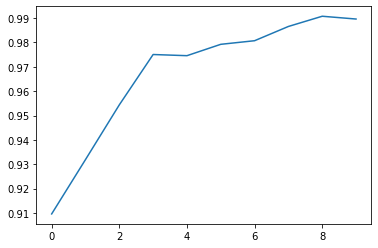

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (11/1000 | Accuracy: 0.9950000643730164 | Loss: 0.009000000543892384, Learning Rate: 0.0002969999914057553)


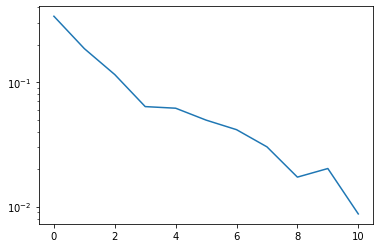

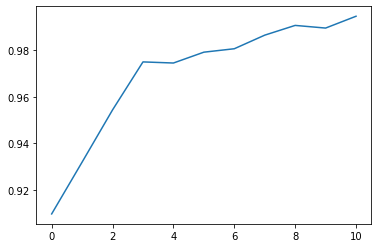

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (12/1000 | Accuracy: 0.9960000514984131 | Loss: 0.007000000216066837, Learning Rate: 0.00029600001289509237)


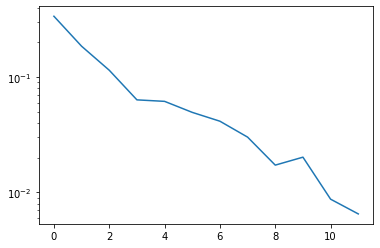

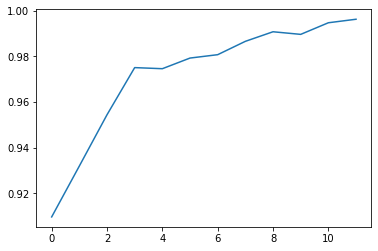

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (13/1000 | Accuracy: 0.9980000257492065 | Loss: 0.003000000026077032, Learning Rate: 0.00029600001289509237)


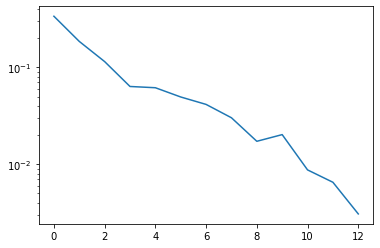

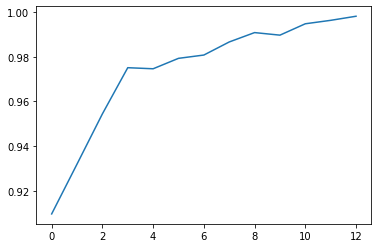

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (14/1000 | Accuracy: 0.9980000257492065 | Loss: 0.003000000026077032, Learning Rate: 0.00029600001289509237)


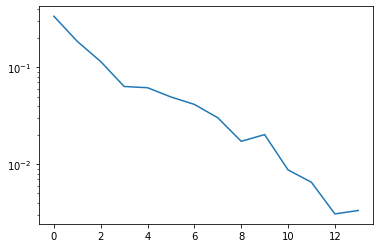

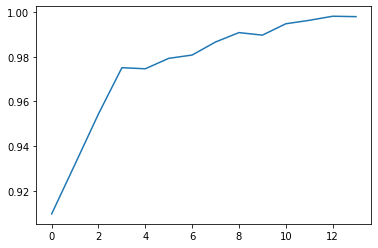

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (15/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029600001289509237)


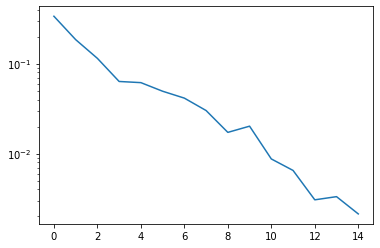

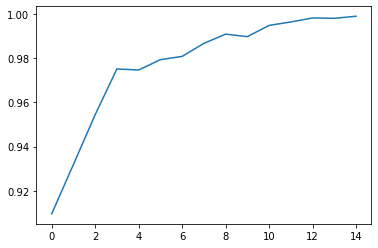

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (16/1000 | Accuracy: 0.9980000257492065 | Loss: 0.003000000026077032, Learning Rate: 0.000295000005280599)


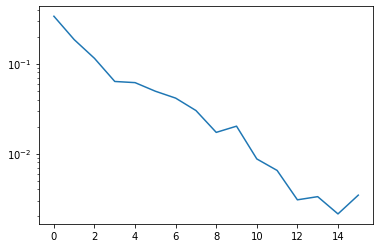

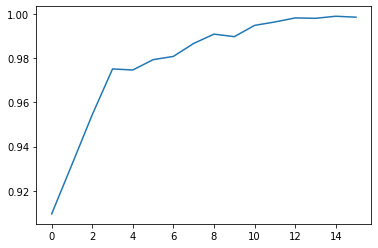

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (17/1000 | Accuracy: 0.9980000257492065 | Loss: 0.003000000026077032, Learning Rate: 0.000295000005280599)


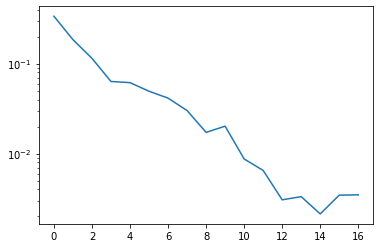

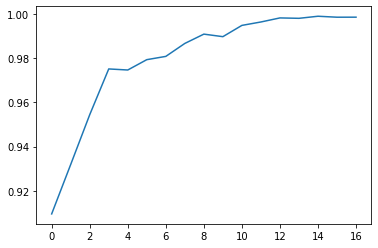

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (18/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.000295000005280599)


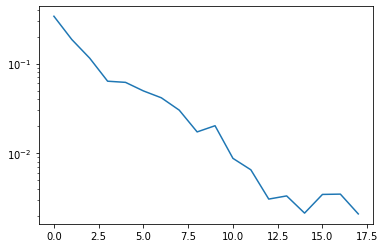

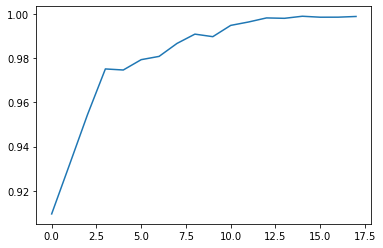

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (19/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00029399999766610563)


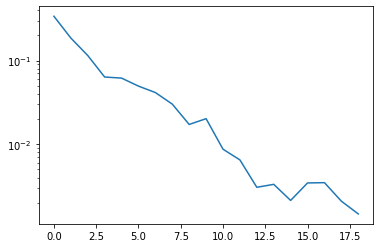

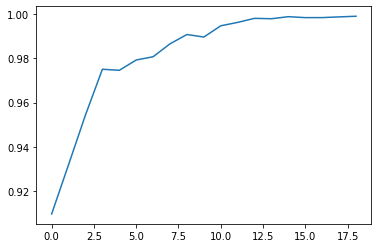

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (20/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029399999766610563)


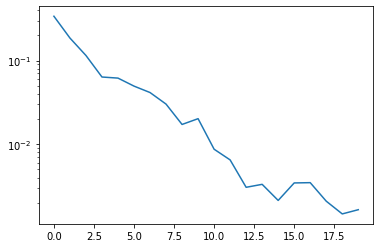

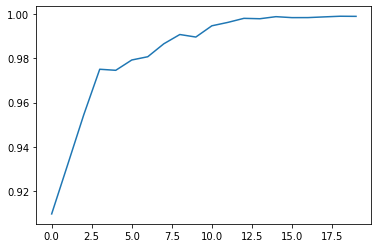

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (21/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029399999766610563)


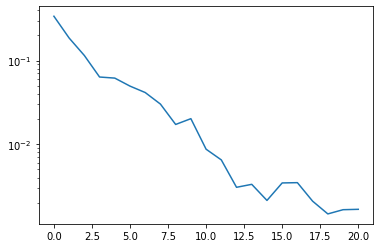

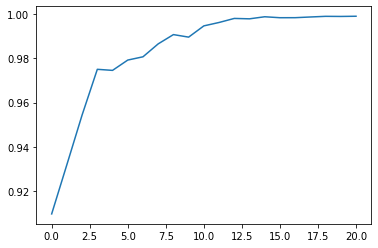

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (22/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00029299999005161226)


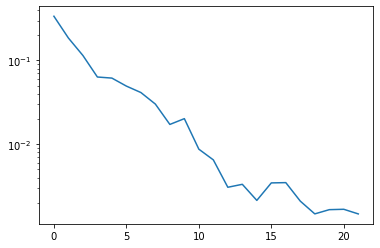

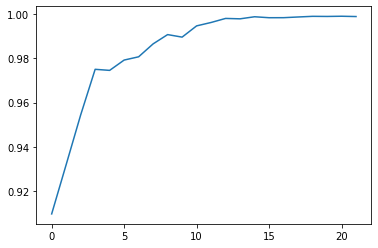

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (23/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029299999005161226)


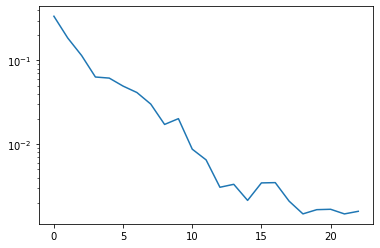

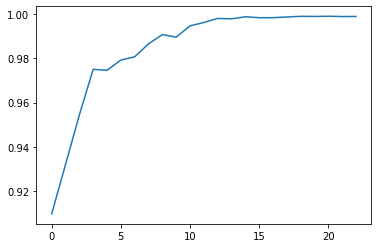

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (24/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029299999005161226)


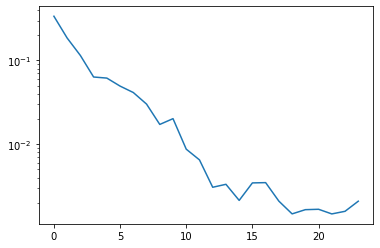

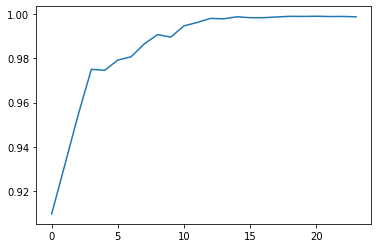

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (25/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00029299999005161226)


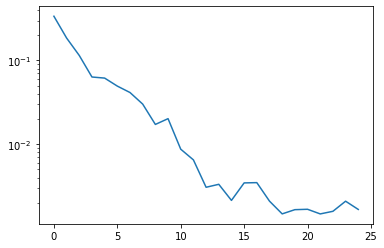

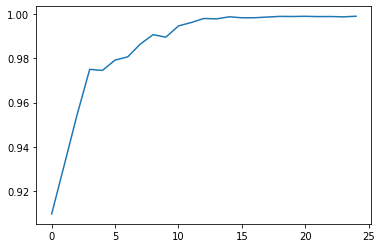

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (26/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00029200001154094934)


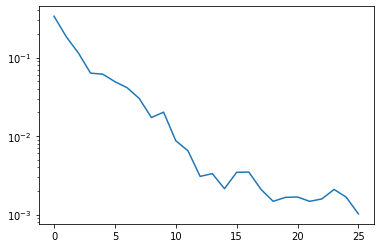

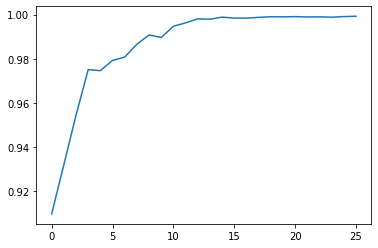

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (27/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00029200001154094934)


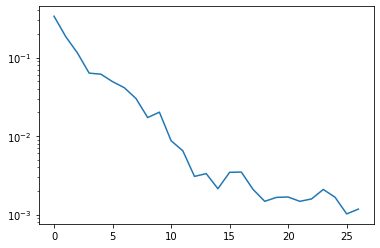

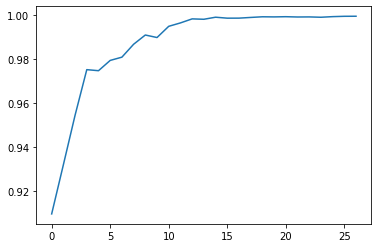

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (28/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00029200001154094934)


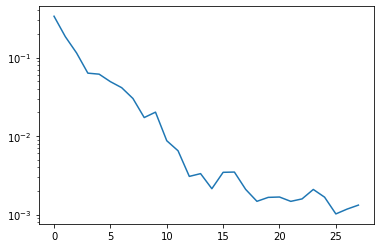

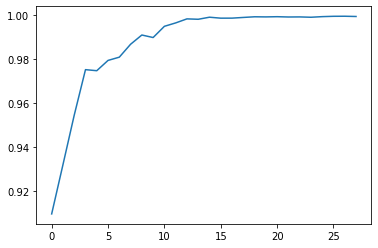

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (29/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.000291000003926456)


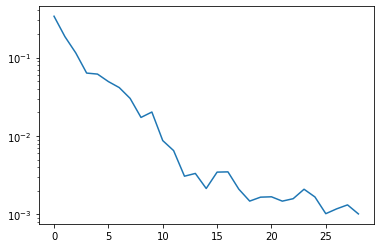

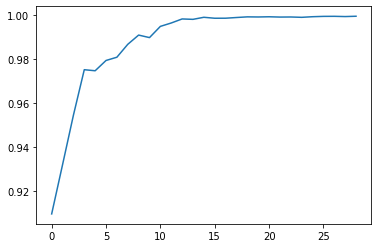

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (30/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.000291000003926456)


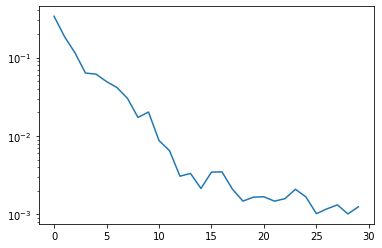

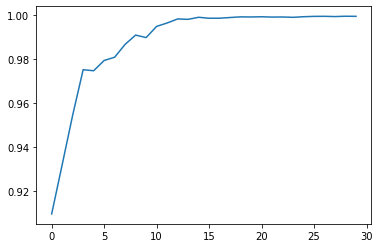

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (31/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.000291000003926456)


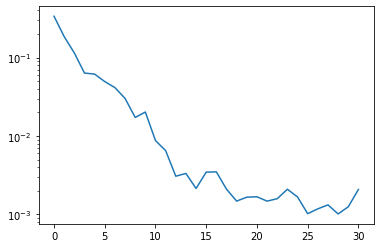

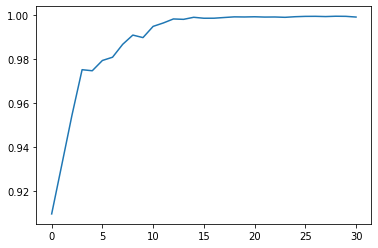

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (32/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.0002899999963119626)


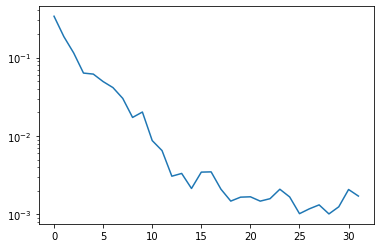

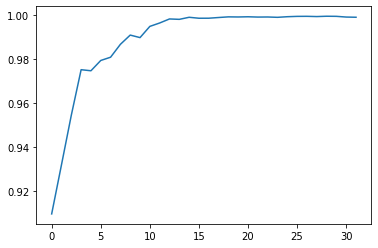

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (33/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002899999963119626)


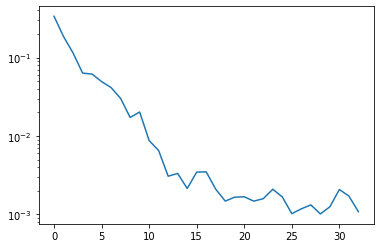

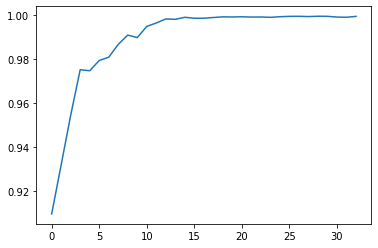

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (34/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002899999963119626)


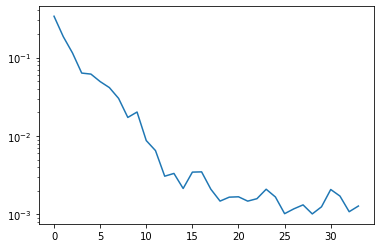

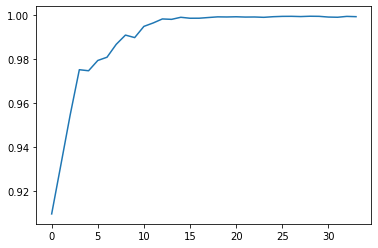

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (35/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002899999963119626)


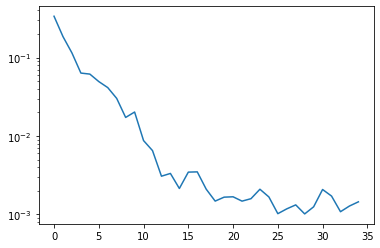

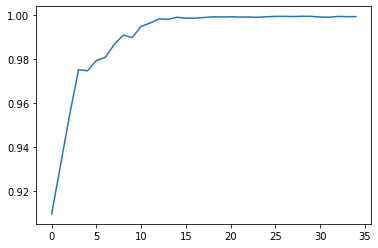

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (36/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00028899998869746923)


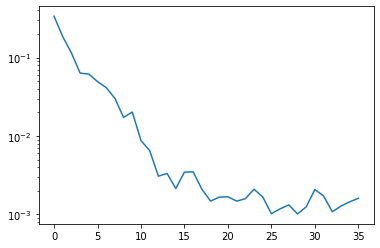

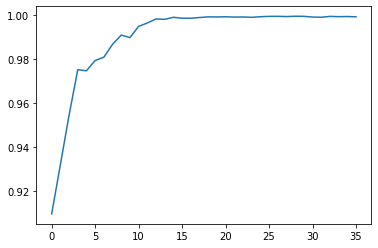

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (37/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00028899998869746923)


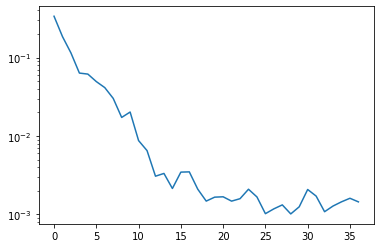

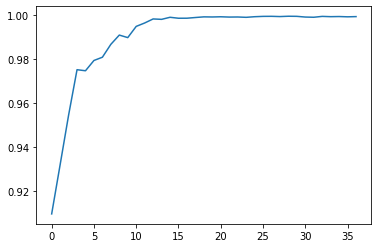

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (38/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00028899998869746923)


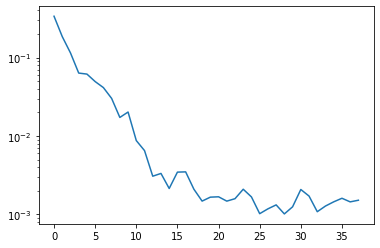

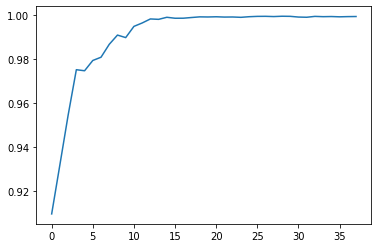

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (39/1000 | Accuracy: 0.999000072479248 | Loss: 0.003000000026077032, Learning Rate: 0.0002880000101868063)


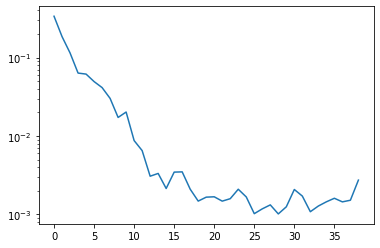

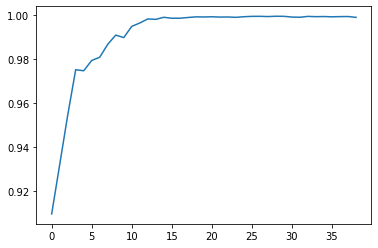

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (40/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002880000101868063)


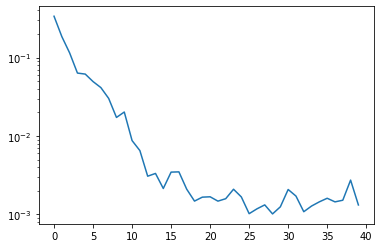

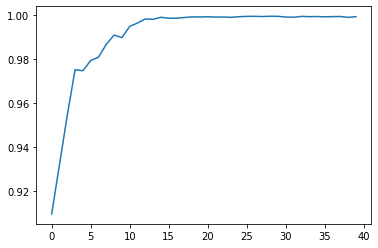

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (41/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002880000101868063)


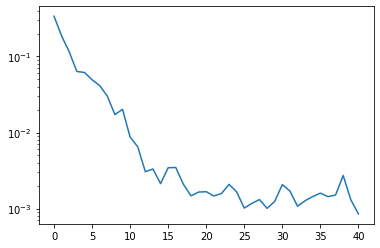

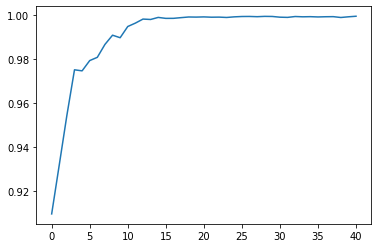

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (42/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00028700000257231295)


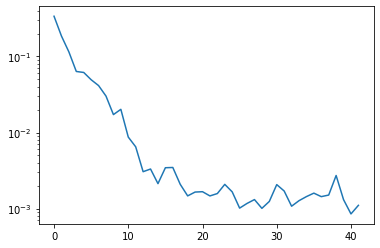

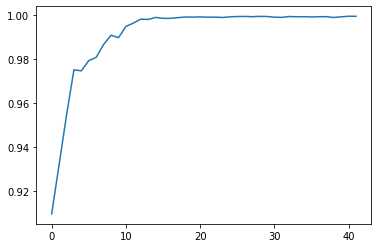

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (43/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.00028700000257231295)


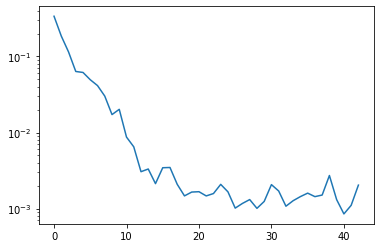

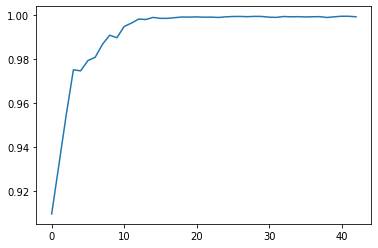

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (44/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00028700000257231295)


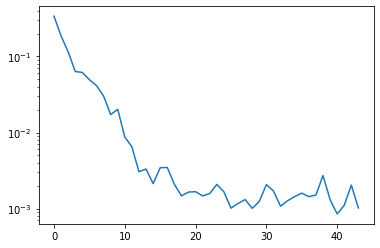

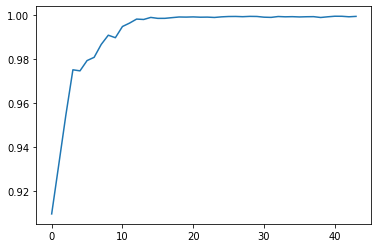

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (45/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.00028700000257231295)


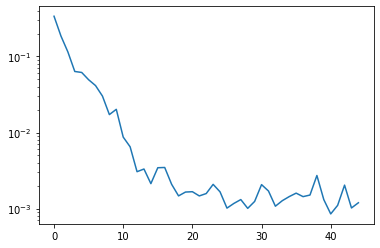

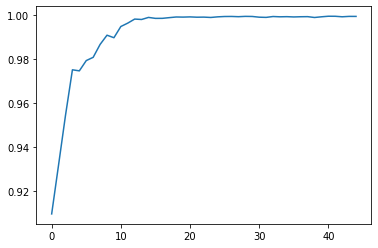

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (46/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.0002859999949578196)


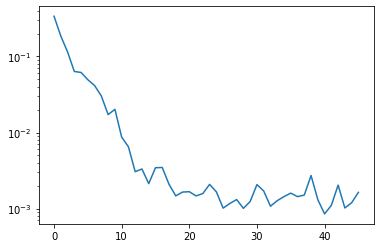

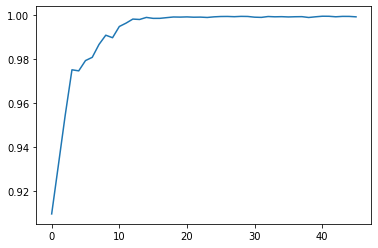

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (47/1000 | Accuracy: 0.999000072479248 | Loss: 0.0020000000949949026, Learning Rate: 0.0002859999949578196)


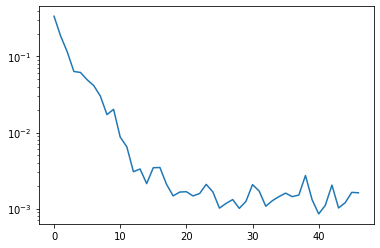

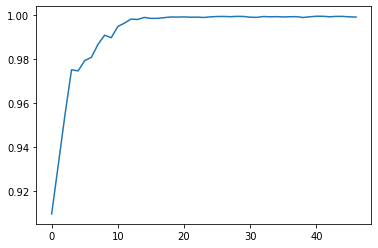

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (48/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002859999949578196)


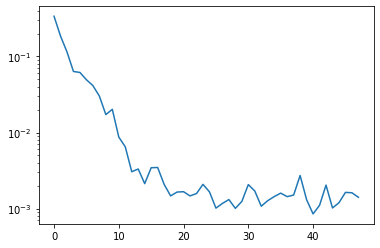

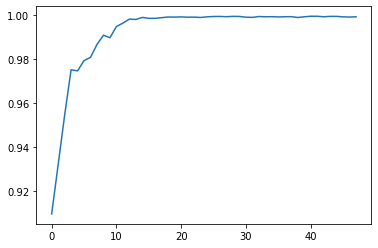

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

Train... (49/1000 | Accuracy: 0.999000072479248 | Loss: 0.0010000000474974513, Learning Rate: 0.0002849999873433262)


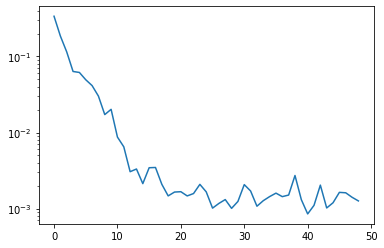

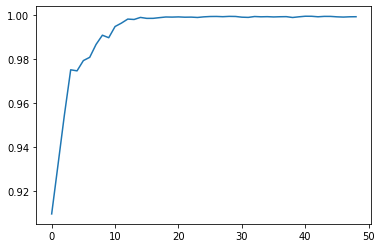

Evaluation...:   0%|          | 0/2 [00:00<?, ?it/s]

Training...:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

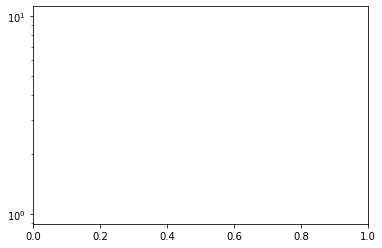

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt

losses = []
accuracies = []

for epoch in tqdm(range(1, num_epochs + 1), desc=f"Epoch ...", position=0, leave=True):
    rng, input_rng = jax.random.split(rng)

    # -- Train --
    train_loader = data_loader(input_rng, my_datasets["train"], total_batch_size, shuffle=True)
    with tqdm(total=len(my_datasets["train"]) // total_batch_size, desc="Training...", leave=False) as progress_bar_train:
        for model_inputs in train_loader:
            # Model forward
            state, train_metric, dropout_rngs = parallel_train_step(state, model_inputs, dropout_rngs)

            progress_bar_train.update(1)

        loss = train_metric['loss'].mean()
        losses.append(loss)
        accuracy = train_metric['accuracy'].mean()
        accuracies.append(accuracy)
        iteration += 1
        progress_bar_train.write(
              f"Train... ({epoch}/{num_epochs} | Accuracy: {round(accuracy, 3)} | Loss: {round(loss, 3)}, Learning Rate: {round(train_metric['learning_rate'].mean(), 6)})"
        )
    plt.plot(losses, label='loss')
    plt.show()
    plt.plot(accuracies, label='accuracy')
    plt.show()
    plt.yscale('log')

    # -- Eval --
    eval_loader = data_loader(input_rng, my_datasets["validation"], total_batch_size)
    eval_metrics = []
   
    with tqdm(total=len(my_datasets["validation"]) // total_batch_size, desc="Evaluation...", leave=False) as progress_bar_eval:
        for model_inputs in eval_loader:
            # Model forward
            eval_metric = parallel_eval_step(state.params, model_inputs)
            eval_metrics.append(eval_metric)

            progress_bar_eval.update(1)
 
        # eval_metrics = get_metrics(eval_metrics)
        # eval_metrics = jax.tree_map(jnp.mean, eval_metrics)
        # progress_bar_eval.write(
        #     f"Eval... ({epoch}/{num_epochs} | Loss: {eval_metrics['loss']} | Perplexity: {eval_metrics['perplexity']})"
        # )

It can be seen that in this colab training already reaches a speed of 2.42 training steps per second. Executing [**`run_clm_flax.py`**](https://github.com/huggingface/transformers/tree/master/examples/flax/language-modeling/run_clm_flax.py) on a TPUv3-8 VM should be as fast as 7 training steps per second.

For a more in-detail comparison of runtimes please refer to [this](https://github.com/huggingface/transformers/tree/master/examples/flax/language-modeling#runtime-evaluation) table.